# Image Data Storage for the Web

## Learning objectives

- Become familiar with the design of modern, **cloud storage systems**
- Gain experience with the **Zarr data format** for web-based scientific computing 
- Understand the relationship between **chunked, compressed**, object storage and **parallel processing and multi-scale visualization**
- Become familiar with **OME-NGFF**, the next-generation file format for scientific imaging

In [ ]:
# Install package dependencies
import sys

!{sys.executable} -m pip install --upgrade --pre zarr multiscale-spatial-image matplotlib itk-io tifffile itkwidgets ome-zarr

# Cloud storage

**Cloud storage services**, such as:

- Amazon Simple Storage Service (AWS S3)
- Google Cloud Storage
- Microsoft Azure Storage
- Minio Cloud Storage

**differ from traditional filesystem storage**.

In *File Storage*:

- Data is organized into files and folders.
- There is generally a pool of storage, e.g. a volume, with limited capacity that can be accessed.
- Data can be overwritten.
- Limited metadata is associated with the file.

In cloud, *Object Storage* systems:

- Objects, binary blobs, live in a flat structure.
- Object have a unique identifier and associated metadata, typically JSON-compatible
- Access is possible via simple HTTP requests
- Object's cannot be modified

## Zarr and n5 formats

[Zarr](https://zarr-developers.github.io/about/) and [n5](https://github.com/saalfeldlab/n5/) are file formats with reference implementatinos that map well to cloud Object Storage services. They are also suitable for storage of large bioimages.

Together zarr and n5 are formats used by the bioimaging data model of the [Open Microscopy Environment (OME)-Next-generation File Format (NGFF)](https://ngff.openmicroscopy.org/latest/), which represents what was previously stored in [OME-TIFF](http://www.openmicroscopy.org/ome-files/) as *a hierarchy of n-dimensional (dense) arrays with metadata*.

Zarr and n5 support:

- Group hierarchies
- Arbitrary JSON-compatible meta-data
- Chunked, n-dimensional binary tensor datasets
- Binary component types: [u]int8, [u]int16, [u]int32, [u]int64, float32, float64
- Next-generation lossless compression with [blosc](https://blosc.org/pages/blosc-in-depth/) of binary chunks.

When combined with a **multiscale image model** such as [OME-NGFF](https://www.nature.com/articles/s41592-021-01326-w), **large image visualization** is possible.

- *You do not need to download the entire volume before you can visualization or analyze it.*
- *Retrieve a partial region-of-interest at a given scale.*

The object storage-compatible model facilitates **parallel processing** because it is conducive to **compressed chunk writes**, even in a cloud storage environment.

## Creating an OME-NGFF

In [2]:
from multiscale_spatial_image import to_multiscale
from spatial_image import is_spatial_image, to_spatial_image
import itk
import numpy as np
from urllib.request import urlretrieve
import os
import zarr
from itkwidgets import view

Download example image

Derived from:

https://data.broadinstitute.org/bbbc/BBBC024/

Image set BBBC024vl [Svoboda David, Kozubkek Michal, Stejskal Stanislav. Generation of Digital Phantoms of Cell Nuclei and Simulation of Image Formation in 3D Image Cytometry. Cytometry Part A, John Wiley & Sons, Inc., 75A, 6, pp. 494-509, 16 pages. ISSN 1552-4922. 2009.] from the Broad Bioimage Benchmark Collection.

In [3]:
image_name= 'HL50_cell'

filename = f'{image_name}.tif'
if not os.path.exists(filename):
    url = 'https://data.kitware.com/api/v1/file/5b61f16c8d777f06857c1949/download'
    urlretrieve(url, filename)

In [4]:
# Image metadata
image = itk.imread(filename)
view(image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [5]:
print(image)

Image (0000022EA0F60F50)
  RTTI typeinfo:   class itk::Image<unsigned short,3>
  Reference Count: 1
  Modified Time: 417
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 232
  UpdateMTime: 416
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [363, 212, 129]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [363, 212, 129]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [363, 212, 129]
  Spacing: [1, 1, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1 0 0
0 1 0
0 0 1

  PointToIndexMatrix: 
1 0 0
0 1 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0000022EA4B4A170)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,unsigned short>
      Reference Count: 3
      Modif

Convert the `itk.Image` to an [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html).

In [6]:
image_da = itk.xarray_from_image(image)
image_da.name = image_name
image_da

<xarray.DataArray 'HL50_cell' (z: 129, y: 212, x: 363)>
array([[[ 95,  96,  84, ...,  89,  93,  97],
        [ 94,  89,  92, ...,  93,  95,  85],
        [ 95,  93,  92, ...,  90,  88,  92],
        ...,
        [ 92,  95,  96, ...,  93,  88,  96],
        [ 91,  92,  93, ...,  91,  88,  93],
        [ 97,  94,  94, ...,  89,  95,  96]],

       [[ 86,  88,  92, ...,  95,  93,  97],
        [ 96,  96,  93, ...,  91,  93,  94],
        [ 85,  95,  82, ...,  91,  86,  92],
        ...,
        [ 91,  91,  87, ...,  91,  90,  98],
        [ 98,  92,  97, ...,  96,  90,  95],
        [ 88,  88,  99, ...,  94,  97,  93]],

       [[ 92,  92,  95, ...,  92,  92,  89],
        [ 96,  94,  93, ...,  95,  96,  89],
        [ 92,  93,  93, ...,  95,  84,  90],
        ...,
...
        ...,
        [ 90,  95,  90, ...,  95,  95, 100],
        [ 96,  95,  93, ...,  99,  96,  89],
        [ 98,  91,  92, ...,  87,  91,  89]],

       [[ 90,  88,  91, ...,  94,  94,  84],
        [ 84,  90,  97, ...,  88, 100,  96],
        [ 93,  96,  95, ...,  89,  87,  96],
        ...,
        [ 89, 100,  92, ...,  92,  91,  87],
        [ 93,  92,  91, ...,  89,  82,  98],
        [ 90,  93,  90, ...,  93,  90,  96]],

       [[ 91,  89,  93, ..., 103,  93,  93],
        [ 97,  90,  91, ...,  94,  90,  89],
        [ 96,  92,  92, ...,  91,  94,  87],
        ...,
        [ 85,  94,  85, ...,  91,  91,  87],
        [ 89,  93,  99, ...,  84,  90,  94],
        [ 99,  99,  92, ...,  90,  91,  86]]], dtype=uint16)
Coordinates:
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0 361.0 362.0
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 ... 207.0 208.0 209.0 210.0 211.0
  * z        (z) float64 0.0 1.0 2.0 3.0 4.0 ... 124.0 125.0 126.0 127.0 128.0
Attributes:
    direction:  [[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]
    Software:   InsightToolkit

In [7]:
# Does the image_da have the characteristics of an xarray.DataArray bioimage with spatial metadata?
is_spatial_image(image_da)

True

OME-NGFF stores a multiscale pyramid for large-scale visualization or analysis. Let's generate it.

In [8]:
multiscale = to_multiscale(image_da, [2,4])
multiscale

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:    (x: 363, y: 212, z: 129)
│       Coordinates:
│         * x          (x) float64 0.0 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0 361.0 362.0
│         * y          (y) float64 0.0 1.0 2.0 3.0 4.0 ... 207.0 208.0 209.0 210.0 211.0
│         * z          (z) float64 0.0 1.0 2.0 3.0 4.0 ... 124.0 125.0 126.0 127.0 128.0
│       Data variables:
│           HL50_cell  (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>
│       Attributes:
│           direction:  [[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]
│           Software:   InsightToolkit
├── DataTree('scale1')
│       Dimensions:    (x: 181, y: 106, z: 64)
│       Coordinates:
│         * x          (x) float64 1.5 3.5 5.5 7.5 9.5 ... 353.5 355.5 357.5 359.5 361.5
│         * y          (y) float64 0.5 2.5 4.5 6.5 8.5 ... 202.5 204.5 206.5 208.5 210.5
│         * z          (z) float64 1.5 3.5 5.5 7.5 9.5 ... 119.5 121.5 123.5 125.5 127.5
│       Data variables:
│           HL50_cell  (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>
│       Attributes:
│           direction:  [[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]
│           Software:   InsightToolkit
└── DataTree('scale2')
        Dimensions:    (x: 45, y: 26, z: 16)
        Coordinates:
          * x          (x) float64 6.5 14.5 22.5 30.5 38.5 ... 334.5 342.5 350.5 358.5
          * y          (y) float64 7.5 15.5 23.5 31.5 39.5 ... 183.5 191.5 199.5 207.5
          * z          (z) float64 4.5 12.5 20.5 28.5 36.5 ... 100.5 108.5 116.5 124.5
        Data variables:
            HL50_cell  (z, y, x) uint16 dask.array<chunksize=(16, 26, 45), meta=np.ndarray>
        Attributes:
            direction:  [[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]
            Software:   InsightToolkit

The `multiscale` data structure is an [`xarray.Datatree`](https://xarray-datatree.readthedocs.io/en/latest/) composed of [`xarray.Dataset`'s](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

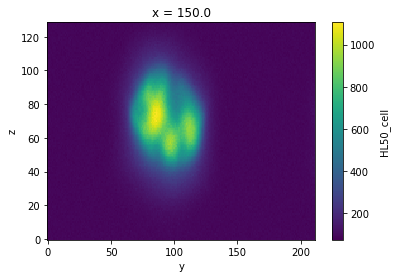

In [9]:
multiscale['scale0'].ds.HL50_cell.isel(x=150).plot.imshow()

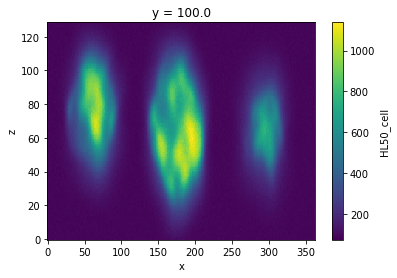

In [10]:
multiscale['scale0'].ds.HL50_cell.isel(y=100).plot.imshow()

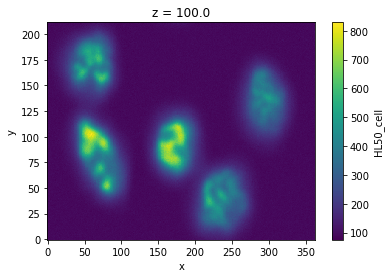

In [11]:
multiscale['scale0'].ds.HL50_cell.isel(z=100).plot.imshow()

In [12]:
view(multiscale['scale1'].ds.HL50_cell)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

## Save the multiscale, chunked image as an OME-NGFF Zarr

In [13]:
output_path = f'{image_name}.zarr'
store = zarr.storage.DirectoryStore(output_path, dimension_separator='/')
multiscale.to_zarr(store)

## Inspect OME-NGFF Zarr content

In [14]:
# Get metadata on an image
!ome_zarr info {output_path}

C:\modern-insights-from-microscopy-images\HL50_cell.zarr [zgroup]
 - metadata
   - Multiscales
 - data
   - (129, 212, 363)
   - (64, 106, 181)
   - (16, 26, 45)


*Examine the contents of the filesystem representation of the OME-Zarr multi-scale image. What information is stored in each file?

In [15]:
%ls {output_path}

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4666-3801

 Directory of C:\modern-insights-from-microscopy-images\HL50_cell.zarr

05/09/2022  11:14 AM    <DIR>          .
05/09/2022  11:14 AM    <DIR>          ..
05/09/2022  11:14 AM             2,853 .zattrs
05/09/2022  11:14 AM                24 .zgroup
05/09/2022  11:14 AM            14,696 .zmetadata
05/09/2022  11:14 AM    <DIR>          scale0
05/09/2022  11:14 AM    <DIR>          scale1
05/09/2022  11:14 AM    <DIR>          scale2
               3 File(s)         17,573 bytes
               5 Dir(s)  879,533,715,456 bytes free


OME-NGFF metadata

In [16]:
%pycat {output_path}{os.sep}.zattrs

Zarr metadata: *.zgroup* identifies a Zarr Group / Path.

In [17]:
%pycat {output_path}{os.sep}.zgroup

The dataset's hierarchical structure follows the filesystem layout.

In [18]:
%ls {output_path}{os.sep}scale0

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4666-3801

 Directory of C:\modern-insights-from-microscopy-images\HL50_cell.zarr\scale0

05/09/2022  11:14 AM    <DIR>          .
05/09/2022  11:14 AM    <DIR>          ..
05/09/2022  11:14 AM               274 .zattrs
05/09/2022  11:14 AM                24 .zgroup
05/09/2022  11:14 AM    <DIR>          HL50_cell
05/09/2022  11:14 AM    <DIR>          x
05/09/2022  11:14 AM    <DIR>          y
05/09/2022  11:14 AM    <DIR>          z
               2 File(s)            298 bytes
               6 Dir(s)  879,533,744,128 bytes free


In [19]:
%ls {output_path}{os.sep}scale0{os.sep}HL50_cell

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4666-3801

 Directory of C:\modern-insights-from-microscopy-images\HL50_cell.zarr\scale0\HL50_cell

05/09/2022  11:14 AM    <DIR>          .
05/09/2022  11:14 AM    <DIR>          ..
05/09/2022  11:14 AM               397 .zarray
05/09/2022  11:14 AM               346 .zattrs
05/09/2022  11:14 AM    <DIR>          0
05/09/2022  11:14 AM    <DIR>          1
05/09/2022  11:14 AM    <DIR>          2
               2 File(s)            743 bytes
               5 Dir(s)  879,533,617,152 bytes free


The *.zarray* files contains metadata about the current multidimensional binary array.

In [20]:
%pycat {output_path}{os.sep}scale0{os.sep}HL50_cell{os.sep}.zarray

Array chunks are indexed by dimension.

In [21]:
%ls {output_path}{os.sep}scale0{os.sep}HL50_cell{os.sep}0

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4666-3801

 Directory of C:\modern-insights-from-microscopy-images\HL50_cell.zarr\scale0\HL50_cell\0

05/09/2022  11:14 AM    <DIR>          .
05/09/2022  11:14 AM    <DIR>          ..
05/09/2022  11:14 AM    <DIR>          0
05/09/2022  11:14 AM    <DIR>          1
05/09/2022  11:14 AM    <DIR>          2
05/09/2022  11:14 AM    <DIR>          3
               0 File(s)              0 bytes
               6 Dir(s)  879,533,293,568 bytes free


Array chunks are stored as compressed binary files.

In [22]:
%ls {output_path}{os.sep}scale0{os.sep}HL50_cell{os.sep}0{os.sep}0

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4666-3801

 Directory of C:\modern-insights-from-microscopy-images\HL50_cell.zarr\scale0\HL50_cell\0\0

05/09/2022  11:14 AM    <DIR>          .
05/09/2022  11:14 AM    <DIR>          ..
05/09/2022  11:14 AM           265,769 0
05/09/2022  11:14 AM           270,699 1
05/09/2022  11:14 AM           265,796 2
05/09/2022  11:14 AM           282,602 3
05/09/2022  11:14 AM           272,626 4
05/09/2022  11:14 AM           195,033 5
               6 File(s)      1,552,525 bytes
               2 Dir(s)  879,533,293,568 bytes free


## Load the OME-NGFF with `zarr`

In [23]:
import zarr
group = zarr.open(f'{output_path}')
group

<zarr.hierarchy.Group '/'>

In [24]:
group.attrs.keys()

dict_keys(['multiscales'])

In [25]:
group.attrs['multiscales']

[{'@type': 'ngff:Image',
  'axes': [{'name': 'x', 'type': 'space'},
   {'name': 'y', 'type': 'space'},
   {'name': 'z', 'type': 'space'}],
  'datasets': [{'coordinateTransformations': [{'scale': [1.0000000150184933,
       1.0000000150184933,
       1.0],
      'type': 'scale'},
     {'translation': [0.0, 0.0, 0.0], 'type': 'translation'}],
    'path': 'scale0/HL50_cell'},
   {'coordinateTransformations': [{'scale': [2.0000000300369867,
       2.000000030036987,
       2.0],
      'type': 'scale'},
     {'translation': [1.5000000225277401, 0.5000000075092467, 1.5],
      'type': 'translation'}],
    'path': 'scale1/HL50_cell'},
   {'coordinateTransformations': [{'scale': [8.000000120147947,
       8.000000120147947,
       8.0],
      'type': 'scale'},
     {'translation': [6.500000097620207, 7.5000001126387, 4.5],
      'type': 'translation'}],
    'path': 'scale2/HL50_cell'}],
  'name': 'HL50_cell',
  'version': '0.4'}]

In [26]:
list(group.keys())

['scale0', 'scale1', 'scale2']

In [27]:
scale0 = group['scale0']

In [28]:
scale0

<zarr.hierarchy.Group '/scale0'>

In [29]:
scale0['HL50_cell']

<zarr.core.Array '/scale0/HL50_cell' (129, 212, 363) uint16>

In [30]:
np.asarray(scale0['HL50_cell'])

array([[[ 95,  96,  84, ...,  89,  93,  97],
        [ 94,  89,  92, ...,  93,  95,  85],
        [ 95,  93,  92, ...,  90,  88,  92],
        ...,
        [ 92,  95,  96, ...,  93,  88,  96],
        [ 91,  92,  93, ...,  91,  88,  93],
        [ 97,  94,  94, ...,  89,  95,  96]],

       [[ 86,  88,  92, ...,  95,  93,  97],
        [ 96,  96,  93, ...,  91,  93,  94],
        [ 85,  95,  82, ...,  91,  86,  92],
        ...,
        [ 91,  91,  87, ...,  91,  90,  98],
        [ 98,  92,  97, ...,  96,  90,  95],
        [ 88,  88,  99, ...,  94,  97,  93]],

       [[ 92,  92,  95, ...,  92,  92,  89],
        [ 96,  94,  93, ...,  95,  96,  89],
        [ 92,  93,  93, ...,  95,  84,  90],
        ...,
        [ 92,  93,  91, ...,  92,  95,  93],
        [ 94,  94,  83, ...,  89,  89,  86],
        [ 90,  90,  92, ...,  86,  92,  96]],

       ...,

       [[ 85,  89,  92, ...,  97,  97,  88],
        [ 95,  92,  92, ...,  88,  96,  90],
        [ 81,  81,  92, ...,  98,  94,  86

## Exercises

Rechunk the multiscale image with a chunk size of 128. *How does the file count change?*

In [31]:
file_count = sum(len(files) for _, _, files in os.walk(f'{output_path}'))
print(file_count)

121


In [32]:
# multiscale_rechunked = multiscale.chunk(128)

# .to_zarr

# count files

Save the OME-NGFF in a [Zarr ZipStore](https://zarr.readthedocs.io/en/stable/api/storage.html). *How does this file count change?*

In [41]:
from zarr.storage import ZipStore

store = ZipStore(f'{output_path}.zip', dimension_separator='/')
multiscale.to_zarr(store, mode='w')